# Uploading to Google Cloud

This will upload to Google Cloud and create a VirtualiZarr json file that we can use to lazy load all the data without making it a Zarr because R doesn't play nice with Zarr.

### Prerequisites

The `py-rocket-geospatial-2` image on the NMFS Openscapes JuptyerHub is already set up with this.

* `pip install google-cloud-storage`
* `sudo apt-get install google-cloud-sdk`

You need to have the Storage Admin role on the bucket or on the folder of a bucket. For example, if you will be uploading to the [NOAA Fisheries Google NODD Public Buckets](https://www.noaa.gov/nodd/datasets#NMFS), you will need to be added as a Storage Admin role to a specific folder.

## Authenticate

Run the following in a terminal. It will open and you authenticate there. It will save `application_default_credentials.json` to `~/.config/gcloud`. If you do not have `google-cloud-sdk` installed, you can install somewhere (like locally) and then copy that file and create it here (in hub or whereever you are running this tutorial).

## Upload the netcdf files

We created these netcdf files in `streamflow_hydrographs.ipynb`. First we set up the bucket client.

In [1]:
# set up bucket client
# stop annoying warnings
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

from google.cloud import storage
from pathlib import Path

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"
destination_prefix = "CB/nwm_daily_means/netcdf"

# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)

## Upload the files

### Start with a test file

In [ ]:
# Set the file you want to test with
test_file = Path("daily_mean_2018.nc")  # change this if using a different file

# Create blob and upload
blob_path = f"{destination_prefix}/{test_file.name}"
blob = bucket.blob(blob_path)
blob.upload_from_filename(str(test_file))

print(f"Uploaded {test_file.name} → gs://{bucket_name}/{blob_path}")


### Now do all the files

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

# Find all .nc files in current directory
nc_files = sorted(Path(".").glob("daily_mean_*.nc"))

for file_path in nc_files:
    destination_blob = f"{folder}/{file_path.name}"
    blob = bucket.blob(destination_blob)
    blob.upload_from_filename(str(file_path))
    print(f"✅ Uploaded {file_path.name} → gs://{bucket_name}/{destination_blob}")


### Lazy loading one file

Note since I put a Zarr file into GCP, it is better to use that with `xarray`. If you are interacting with files in the cloud, you have to open them and send the opened file link to `xarray`. This is why working with Zarr is much better. It is designed for easy cloud access and cloud-computing.

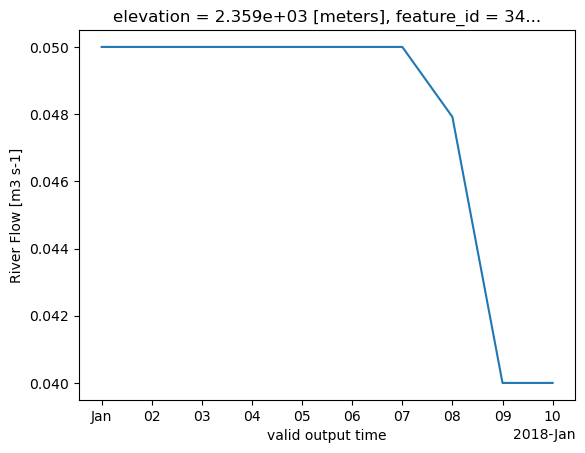

In [31]:
import xarray as xr
import fsspec

url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/netcdf/daily_mean_2018.nc"

# Open anonymous GCS
fs = fsspec.filesystem("gcs", anon=True)

# Open file
f = fs.open(url, mode="rb")

# Load
ds = xr.open_dataset(f)  # lazy load

subset = ds.isel(feature_id=1).sel(time=slice("2018-01-01", "2018-01-10"))
subset["streamflow"].plot()

# close the file when you're completely done
f.close()



## Zarr file

I will also upload a Zarr as this will be more efficient for cloud computing. It will make it easy to lazy load in all the data and work efficiently with it in one large data cube with all years.

### Lazy load in all the netcdf files

In [2]:
import xarray as xr

ds = xr.open_mfdataset(
    "daily_mean_*.nc",
    combine="by_coords",
    parallel=True,
    chunks={}  # let the files load first, we'll rechunk explicitly
)

# Rechunk to Zarr-compatible layout
ds = ds.chunk({
    "feature_id": 5000,
    "time": 365  # uniform chunks except last chunk (Zarr requirement)
})

In [30]:
# double check the chunking. Should be yearly with 5000 feature_ids
ds.chunks

Frozen({'time': (365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 12), 'feature_id': (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 2215)})

In [4]:
# Auth for GCS
import gcsfs
fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")

# GCS destination
zarr_path = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/zarr"

# Write Zarr
ds.to_zarr(
    zarr_path,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"},
    mode="w",
    consolidated=True
)

print("Zarr uploaded to GCS!")

Zarr uploaded to GCS!


### Lazy loading the Zarr file

In [6]:
import xarray as xr

zarr_url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/zarr"

ds = xr.open_zarr(
    zarr_url,
    consolidated=True
)


In [9]:
ds

<xarray.Dataset> Size: 13GB
Dimensions:     (feature_id: 102215, time: 16072)
Coordinates:
    elevation   (feature_id) float32 409kB dask.array<chunksize=(5000,), meta=np.ndarray>
  * feature_id  (feature_id) int64 818kB 341095 341097 ... 948070587 948090493
    gage_id     (feature_id) |S15 2MB dask.array<chunksize=(5000,), meta=np.ndarray>
    latitude    (feature_id) float32 409kB dask.array<chunksize=(5000,), meta=np.ndarray>
    longitude   (feature_id) float32 409kB dask.array<chunksize=(5000,), meta=np.ndarray>
    order       (feature_id) int32 409kB dask.array<chunksize=(5000,), meta=np.ndarray>
  * time        (time) datetime64[ns] 129kB 1979-02-01 1979-02-02 ... 2023-02-01
Data variables:
    streamflow  (time, feature_id) float64 13GB dask.array<chunksize=(365, 5000), meta=np.ndarray>

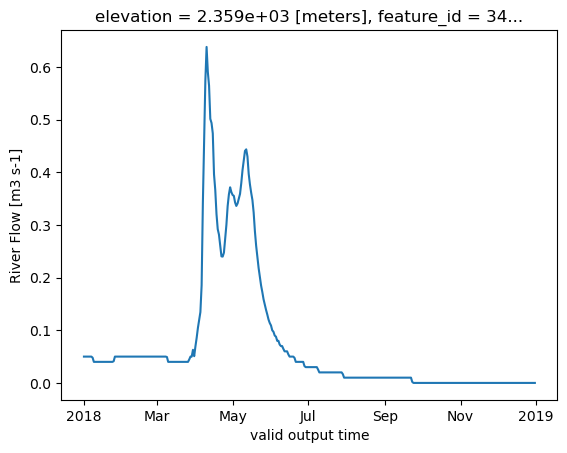

In [10]:
# Make a plot
subset = ds["streamflow"].sel(time="2018").isel(feature_id=1).plot()


Note if this were a private bucket you command to load would be
```
import xarray as xr

zarr_url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/zarr"

ds = xr.open_zarr(
    zarr_url,
    consolidated=True,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"}
)
```


## Summary

We uploaded netcdf and Zarr directory to Google Cloud. Some workflows are based on downloading netcdf files, so I uploaded those but if you want to interact with the data by only getting the subsets that you need, then you will want to work with the Zarr files. Unfortunately, R tooling does not yet work well with Zarr files, but it is catching up.

## Extras

I actually forgot to chunk and so did this to chunk before uploading. For the Zarr, I do the chunking are part fo the lazy loading step so did not need to change the netcdf files.

In [ ]:
import tempfile
import xarray as xr
import gcsfs

fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")
bucket = "nmfs_odp_nwfsc"
prefix = "CB/nwm_daily_means/netcdf"
years = range(1979, 2024)

for year in years:
    print(f"Processing {year}...")

    in_path = f"daily_mean_{year}.nc"
    ds = xr.open_dataset(in_path)

    # chunk sizes
    feature_chunk = min(5000, ds.sizes["feature_id"])
    time_chunk = ds.sizes["time"]
    ds = ds.chunk({"feature_id": feature_chunk})

    # Encoding for feature_id only
    encoding = {
        "streamflow": {
            "chunksizes": (time_chunk, feature_chunk), 
            "zlib": True,
            "complevel": 4
        }
    }

    gcs_path = f"{bucket}/{prefix}/daily_mean_{year}.nc"
    print(f"Writing and uploading to gs://{gcs_path}")

    with tempfile.NamedTemporaryFile(suffix=".nc") as tmp:
        ds.to_netcdf(tmp.name, encoding=encoding, engine="netcdf4")
        fs.put(tmp.name, gcs_path)

    print(f"Uploaded {year}")